# Download crystal structures from the PDB

Download experimental structures of the **CDK2** protein from the Protein Data Bank.

In [13]:
import pandas as pd
import numpy as np
import nglview
from pathlib import Path
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt

## Inputs
This notebook requires to specify the following values
- `prot_name`: the name of the protein.
- `uniprot_id`: Uniprot Accession number.
- `ref_struc_id`: PDB id of the reference structure.
- `ref_ligand_name`: Three letters name of the cocrystalized ligand in the reference structure.


In [2]:
prot_name       = 'cdk2'
uniprot_id      = 'P24941'
ref_struc_id    = '1fin'
ref_ligand_name = 'ATP'

- Get the protein sequence from uniprot.

In [4]:
from helper_modules.pdbs_from_uniprot import get_seq_from_uniprot

seq_prot = get_seq_from_uniprot(uniprot_id)
print(seq_prot)
print(f'\nProtein {prot_name} ({uniprot_id}) has {len(seq_prot)} residues.')

MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL

Protein cdk2 (P24941) has 298 residues.


- Get associated PDB structures to the given UniProt accession number.

In [5]:
# Get the pdbids and some metadata from uniprot
from helper_modules.pdbs_from_uniport import get_useful_pdbids
from helper_modules.pdbs_from_uniport import get_pdb_ids_from_uniprot
from helper_modules.pdbs_from_uniport import get_structure_sequence

# Get the pdbids and some metadata from uniprot
df_pdb_ids = get_pdb_ids_from_uniprot(uniprot_id)

# Get the reference structure and its sequence and residue positions
seq_cry, positions_cry = get_structure_sequence(ref_struc_id)
print(positions_cry[0], positions_cry[-1])

# Select only those entries that match the positions of the reference structure
# with a tolerance of 10 missing residues in the N-term and C-term regions
n_term_tol = 10
c_term_tol = 10
df_pdb_ids = get_useful_pdbids(df_pdb_ids, 
                                  positions_cry,
                                  thr_tol = (n_term_tol, c_term_tol))

# Save the dataframe
df_pdb_ids.to_pickle(f'./df_{prot_name}_pdbids.pkl')
df_pdb_ids.head()

,pdb_id,method,resolution,chain,start,end,seq_len
0,1aq1,X-ray,2.00,A,1,298,298
1,1b38,X-ray,2.00,A,1,298,298
2,1b39,X-ray,2.10,A,1,298,298
3,1buh,X-ray,2.60,A,1,298,298
4,1ckp,X-ray,2.05,A,1,298,298


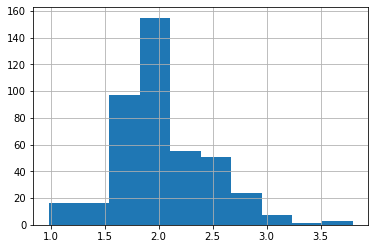

Chain ids:


A    419
L      2
B      1
P      1
C      1
X      1
Name: chain, dtype: int64

In [30]:
n_confs = df_pdb_ids.shape[0]

df_pdb_ids['resolution'].astype(float).hist()
plt.show()

print('Chain ids:')
df_pdb_ids['chain'].value_counts()

# Reference structure


## Get structural information from the reference structure

In [19]:
# Get the reference structure and its sequence and residue positions
seq_cry, positions_cry = get_structure_sequence(ref_struc_id)
seq_cry

'MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL'

In [24]:
ref_prot = parsePDB(ref_struc_id).select('chain A')
pocket_sel = ref_prot.select(
    f'within 8 of resname {ref_ligand_name} and protein')
pocket_residues = [str(i) 
                   for i in np.unique(
                       pocket_sel.getResnums())
                  ]
pocket_residues_str = ' '.join(pocket_residues)
lig_resnum = ref_prot.select(
                       f'resname {ref_ligand_name}'
                 ).getResnums()[0]

- Visualize using `nglview`

In [35]:
view = nv.show_prody(ref_prot)
view.clear_representations()
view.add_representation('cartoon', 
    selection='protein and chain A', color='sstruc')
view.add_cartoon(selection = pocket_residues_str, color='red')
view.add_line(selection = pocket_residues_str)
view.add_representation('spacefill', selection = f'{lig_resnum}')
view.parameters = {
    "fogNear": 0, "fogFar": 100,
}
view

NGLWidget()

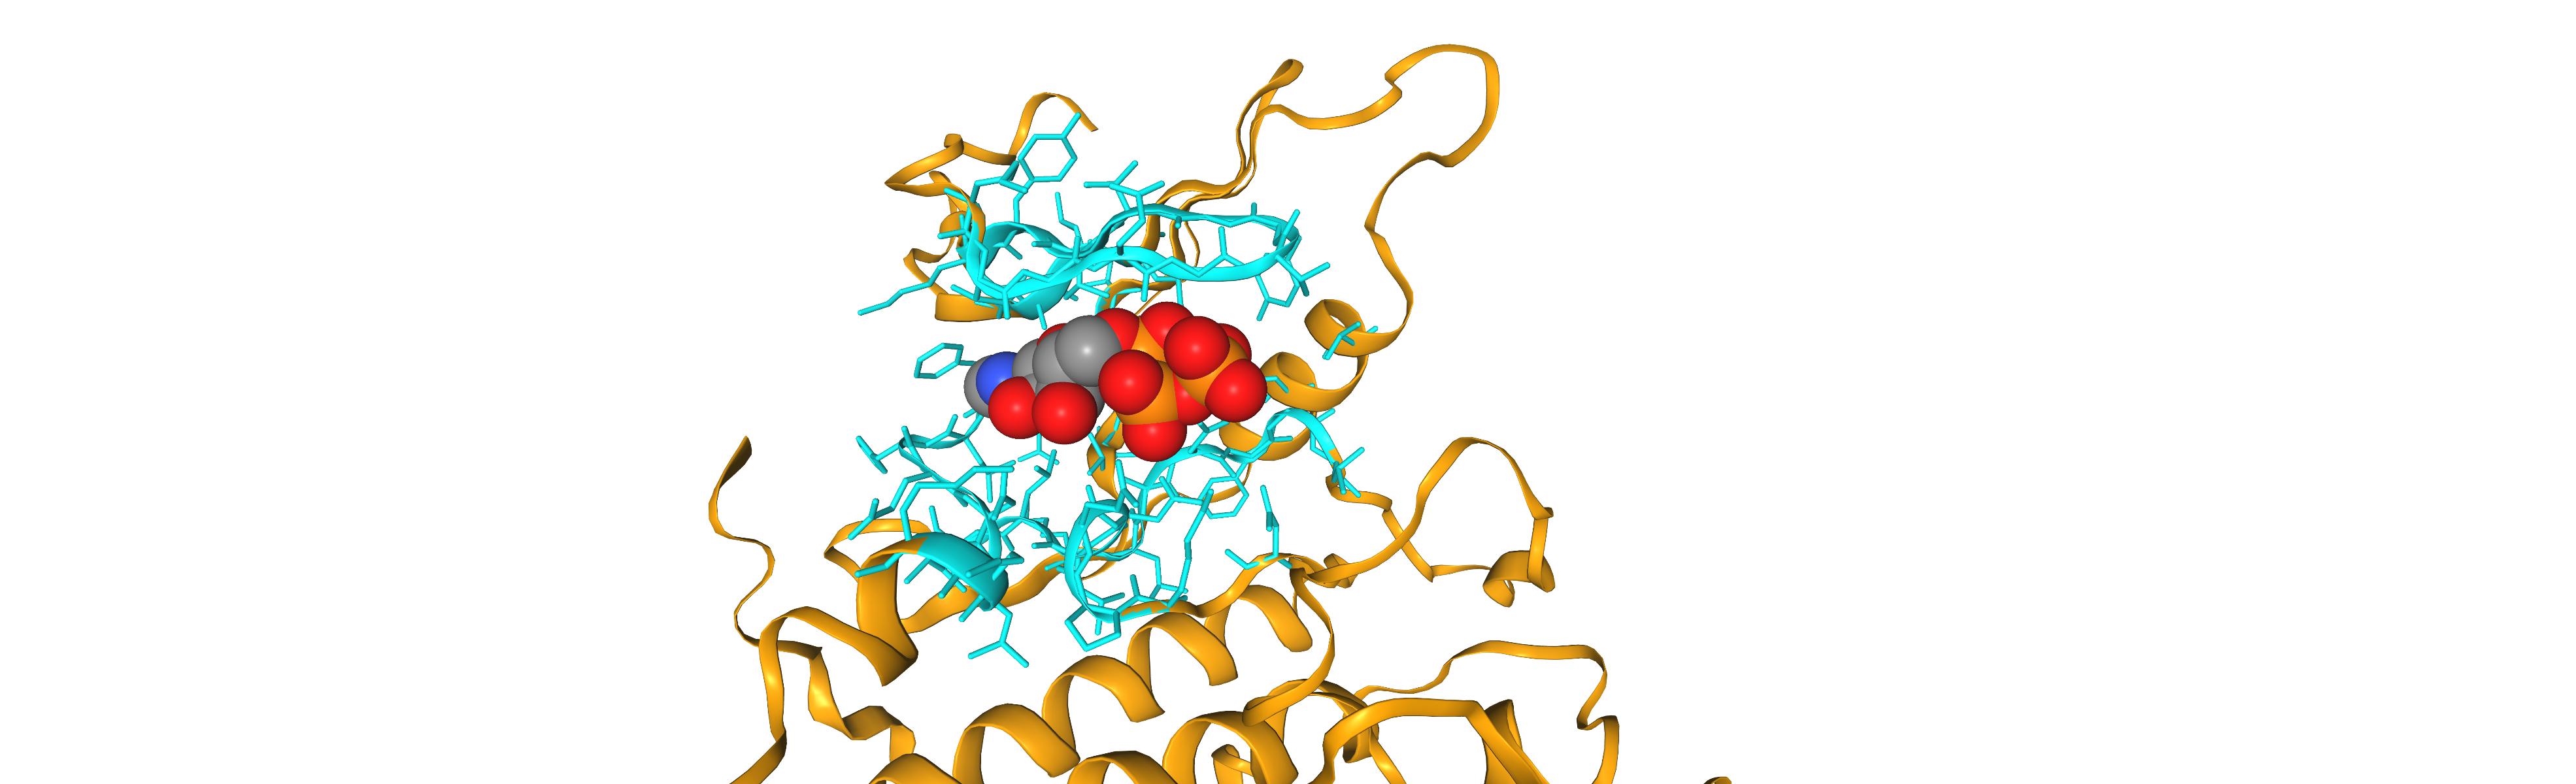

In [27]:
view.render_image()
view._display_image()

## Download the PDB structures
1. Create the output directories

In [28]:
# Define the output directories
OUT_MAIN       = '../data/crystal_confs/'
OUT_DIR_RAW    = f'./{OUT_MAIN}/raw_structures'
OUT_DIR_CHAINS = f'./{OUT_MAIN}/pdb_chains'
OUT_DIR_LIGS   = f'./{OUT_MAIN}/raw_ligands'

# Create the directories if necessary
for path in [OUT_DIR_RAW, OUT_DIR_CHAINS, OUT_DIR_LIGS]:
    Path(path).mkdir(parents = True, exist_ok = True)

2. Use `prody` to download and process the pdb chain belonging to the target protein.
    - The `1fin` structure will be used as a reference structure.
    - All CDK2 chains will be aligned to the reference structure.
    - All CDK2 chains will be renamed to `A`

In [31]:
from prody import parsePDB, matchAlign, writePDB

# We will use the reference structure to define the start and end
ref_chain = ref_prot.select('protein and chain A')
start_res = ref_prot.getResnums()[0] 
end_res   = ref_prot.getResnums()[-1]

# Overlap and Sequence Identity thresholds
overlap = 80
seqid   = 95
residues_algn = pocket_residues_str 

# Iterate over the list of pdb_ids and download the structures
for i, (pdb_id, chid) in df_pdb_ids[['pdb_id', 'chain']].iterrows():
    # Download the full structure
    raw_pdb = parsePDB(pdb_id, folder = OUT_DIR_RAW)
    # Keep the protein chain
    pdb_chain = raw_pdb.select(f'protein and chain {chid}')
    pdb_chain.setChids("A")
    # Keep the same starting and ending points as the reference
    pdb_chain = pdb_chain.select(f'resnum {start_res}to{end_res}')
    # Make the structure alignment regarding the ref_prot
    pdb_alg = matchAlign(
                mobile = pdb_chain,
                target = ref_chain,
                # If the overlap or the seqid thresholds are not met
                # the alignment will return None
                overlap = overlap,
                seqid = seqid,
                tarsel  = f'chain A ca and resnum {residues_algn}'
              )
    # If the alignment returned `None`, skip the next steps
    if not pdb_alg:
        continue
    # Get the aligned structure
    protein = pdb_alg[0]
    # Set the same chain id (A) for all structures
    protein.setChids("A")
    # Save the PDB chain
    chain_pdb_file = f'{OUT_DIR_CHAINS}/{pdb_id}_A.pdb'
    writePDB(chain_pdb_file, protein)
    # Save the non proteic atoms (raw ligands)
    ligand = raw_pdb.select('hetatm')
    if ligand:
        raw_ligand_file = f'{OUT_DIR_LIGS}/{pdb_id}_lig.pdb'
        writePDB(raw_ligand_file, ligand)

Finished!